In [2]:
import janitor
import matplotlib.pyplot as plt
import missingno as msno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets 

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic
from sklearn import set_config

import warnings
warnings.filterwarnings('ignore')

In [26]:
%run pandas-missing-extension.ipynb

In [4]:
nhanes_raw_df = nhanes.load.load_NHANES_data(year = '2017-2018').clean_names(case_type = 'snake')
nhanes_raw_df

,general_health_condition,ever_breastfed_or_fed_breastmilk,age_stopped_breastfeedingdays,age_first_fed_formuladays,age_stopped_receiving_formuladays,age_started_other_foodbeverage,age_first_fed_milkdays,type_of_milk_first_fed_whole_milk,type_of_milk_first_fed2_milk,type_of_milk_first_fed1_milk,...,days_smoked_cigs_during_past30_days,avg_cigarettesday_during_past30_days,tried_to_quit_smoking,times_stopped_smoking_cigarettes,how_long_were_you_able_to_stop_smoking,unit_of_measure_dayweekmonthyear_2_smq,current_selfreported_height_inches,current_selfreported_weight_pounds,tried_to_lose_weight_in_past_year,times_lost10_lbs_or_more_to_lose_weight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,0.0,Never
102953.0,Fair or,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,65.0,218.0,0.0,Never
102954.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,150.0,0.0,Never


In [20]:
nhanes_selected = nhanes_raw_df.select_columns('general_health_condition', 
                                               'age_in_years_at_screening',
                                               'gender',
                                               'current_selfreported_weight_pounds',
                                               'current_selfreported_height_inches',
                                               'doctor_told_you_have_diabetes',
                                               '60_sec_pulse30_sec_pulse2',
                                               'total_cholesterol_mgdl').rename_columns({
                                                'age_in_years_at_screening': 'age',
                                                'current_selfreported_weight_pounds': 'weight',
                                                'current_selfreported_height_inches': 'height',
                                                'doctor_told_you_have_diabetes': 'diabetes',
                                                '60_sec_pulse30_sec_pulse2': 'pulse',
                                                'total_cholesterol_mgdl': 'cholesterol'
                                                })

nhanes_selected

,general_health_condition,age,gender,weight,height,diabetes,pulse,cholesterol
SEQN,,,,,,,,
93703.0,NaN,2.0,Female,NaN,NaN,0,NaN,NaN
93704.0,NaN,2.0,Male,NaN,NaN,0,NaN,NaN
93705.0,Good,66.0,Female,165.0,63.0,0,52.0,157.0
93706.0,Very good,18.0,Male,145.0,68.0,0,82.0,148.0
93707.0,Good,13.0,Male,NaN,NaN,0,100.0,189.0
...,...,...,...,...,...,...,...,...
102952.0,Very good,70.0,Female,117.0,NaN,Borderline,68.0,119.0
102953.0,Fair or,42.0,Male,218.0,65.0,0,78.0,182.0
102954.0,Good,41.0,Female,150.0,66.0,0,78.0,172.0


In [13]:
nhanes_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8366 entries, 93703.0 to 102956.0
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   general_health_condition  5964 non-null   object 
 1   age                       8366 non-null   float64
 2   gender                    8366 non-null   object 
 3   weight                    5828 non-null   float64
 4   height                    5776 non-null   float64
 5   diabetes                  8362 non-null   object 
 6   pulse                     6742 non-null   float64
 7   cholesterol               6738 non-null   float64
dtypes: float64(5), object(3)
memory usage: 588.2+ KB


## Comportamiento estadístico de las variables

In [14]:
nhanes_selected.describe()

,age,weight,height,pulse,cholesterol
count,8366.000000,5828.000000,5776.000000,6742.000000,6738.000000
mean,35.830026,350.995710,272.224030,73.749926,179.894627
std,24.905061,1280.908078,1414.518896,12.380546,40.602248
min,1.000000,72.000000,49.000000,34.000000,76.000000
25%,12.000000,145.000000,63.000000,66.000000,151.000000
50%,33.000000,171.500000,66.000000,72.000000,176.000000
75%,59.000000,208.000000,70.000000,82.000000,204.000000
max,80.000000,9999.000000,9999.000000,136.000000,446.000000


In [15]:
nhanes_selected.describe(include = 'object')

,general_health_condition,gender,diabetes
count,5964,8366,8362
unique,5,2,3
top,Good,Female,0
freq,2454,4272,7334


In [16]:
nhanes_selected.height.value_counts()

height
66.0      540
64.0      514
65.0      469
62.0      459
67.0      446
63.0      421
68.0      397
70.0      374
69.0      365
71.0      317
61.0      289
72.0      257
60.0      226
73.0      156
9999.0    119
59.0      112
74.0      105
75.0       73
76.0       39
58.0       24
57.0       19
77.0       16
56.0       10
78.0        8
53.0        5
54.0        4
55.0        3
79.0        2
50.0        2
49.0        1
7777.0      1
81.0        1
82.0        1
51.0        1
Name: count, dtype: int64

## Desenmascarar datos nulos

- Convertir los datoss 9999 o 7777 a nulos (Pandas no los identifica como tal)

In [21]:
nhanes_selected = nhanes_selected.replace({'height': {9999:np.nan, 7777:np.nan},
                                           'weight': {7777:np.nan, 9999:np.nan}})
nhanes_selected.describe()

,age,weight,height,pulse,cholesterol
count,8366.000000,5724.000000,5656.000000,6742.000000,6738.000000
mean,35.830026,178.805556,66.249646,73.749926,179.894627
std,24.905061,48.688953,4.154477,12.380546,40.602248
min,1.000000,72.000000,49.000000,34.000000,76.000000
25%,12.000000,145.000000,63.000000,66.000000,151.000000
50%,33.000000,170.000000,66.000000,72.000000,176.000000
75%,59.000000,205.000000,69.000000,82.000000,204.000000
max,80.000000,484.000000,82.000000,136.000000,446.000000


## Variables desbalanceadas

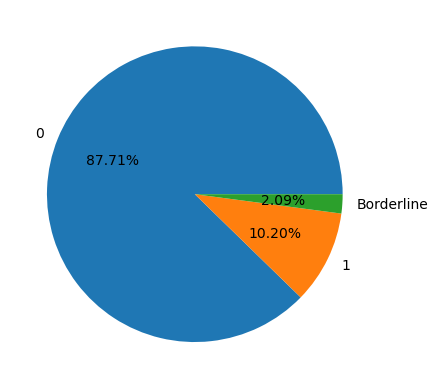

In [22]:
plt.pie(x = nhanes_selected.diabetes.value_counts(), labels = nhanes_selected.diabetes.value_counts().index, autopct = '%0.2f%%')
plt.show()

In [23]:
nhanes_selected = nhanes_selected.replace({'diabetes': {'Borderline': np.nan}})
nhanes_selected.describe(include = 'object')

,general_health_condition,gender,diabetes
count,5964,8366,8187
unique,5,2,2
top,Good,Female,0
freq,2454,4272,7334


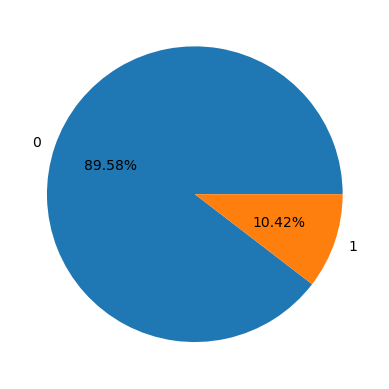

In [24]:
plt.pie(x = nhanes_selected.diabetes.value_counts(), labels = nhanes_selected.diabetes.value_counts().index, autopct = '%0.2f%%')
plt.show()

## Pipeline

- Reordena columnas según la cantidad de nulos que tengan
- Elimina las filas donde diabetes sea nulo
- Transforma la columna diabetes a entero

In [27]:
nhanes_df = (nhanes_selected.missing.sort_variables_by_missingness().dropna(subset = ['diabetes'], how = 'any').transform_column(column_name = 'diabetes', function = lambda x: x.astype(int), elementwise = False))
nhanes_df

,height,weight,general_health_condition,cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,4.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


## Visualización Nulos

<Axes: >

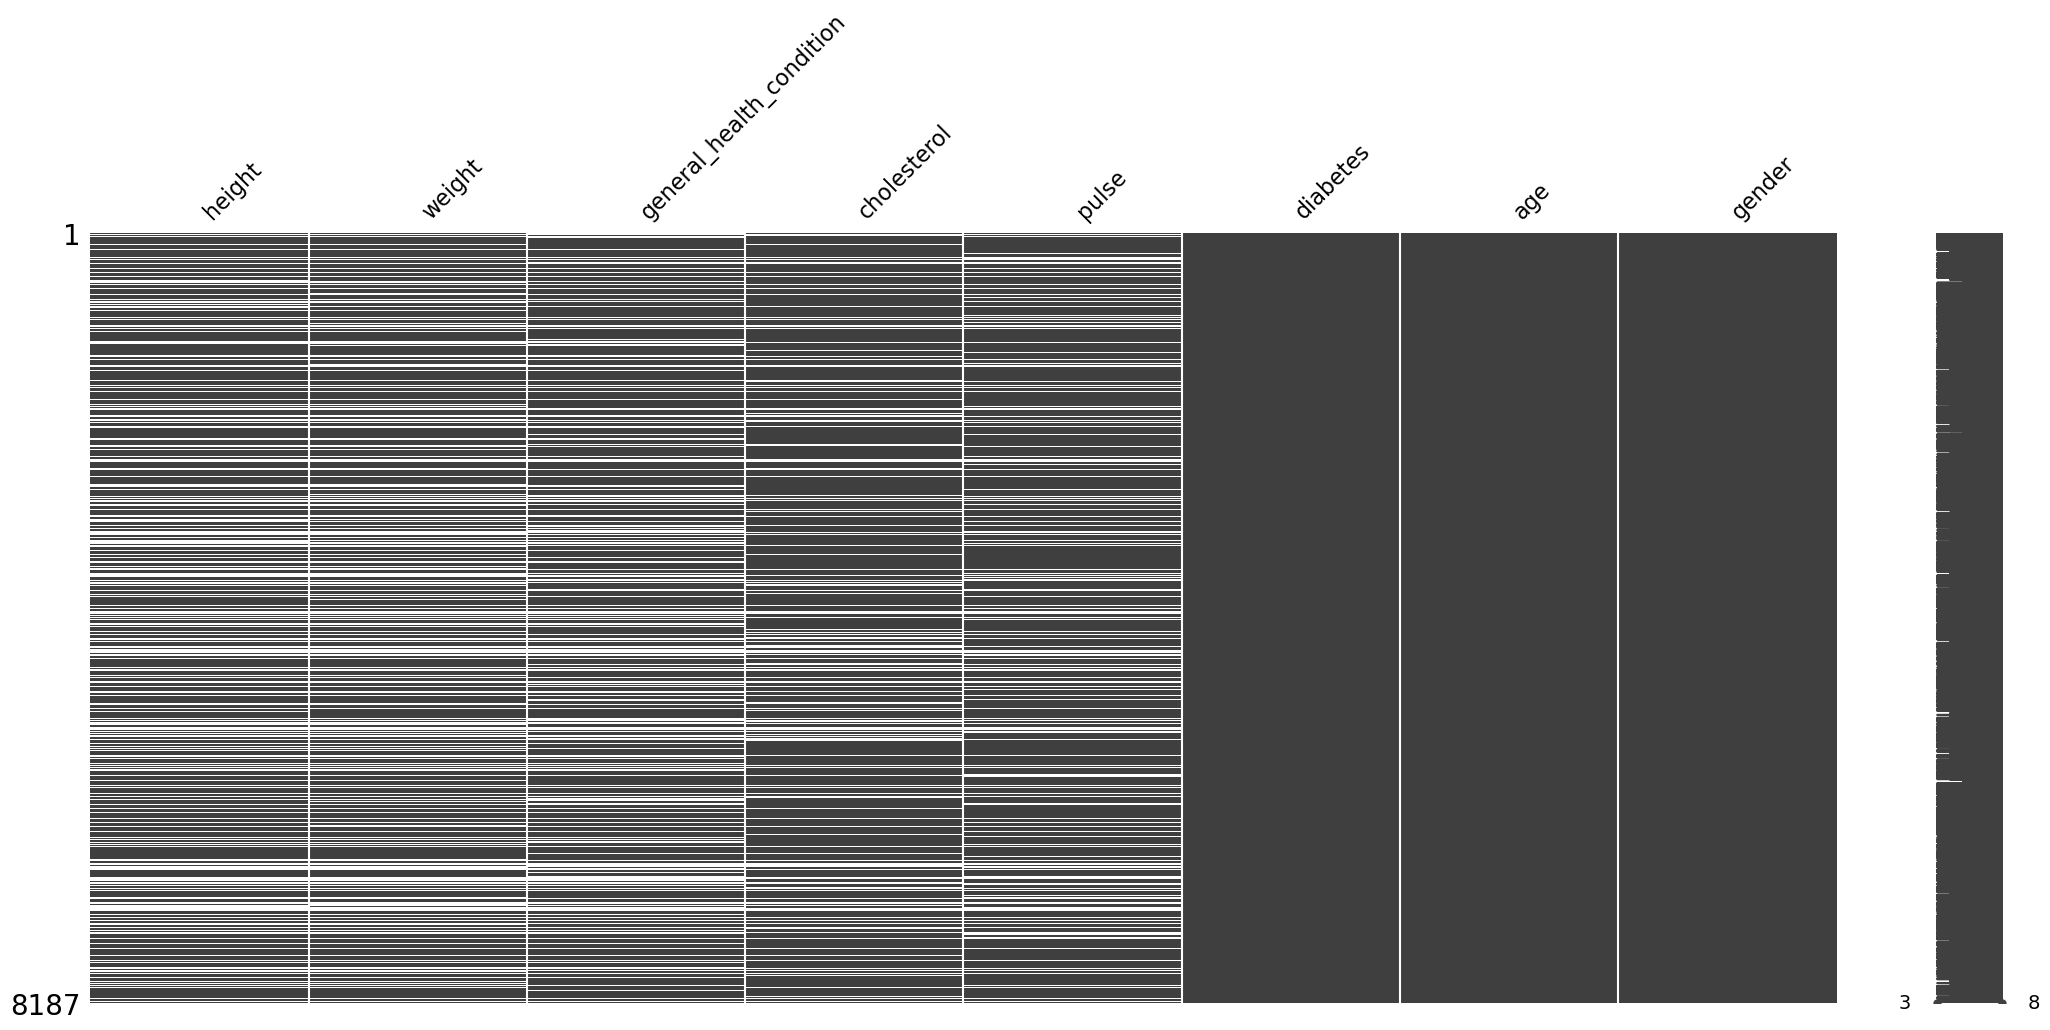

In [28]:
msno.matrix(nhanes_df)

In [29]:
nhanes_df.dropna(subset = ['pulse', 'cholesterol', 'general_health_condition', 'weight' , 'height'], how = 'all', inplace = True)
nhanes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7157 entries, 93705.0 to 102956.0
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   height                    5488 non-null   float64
 1   weight                    5553 non-null   float64
 2   general_health_condition  5797 non-null   object 
 3   cholesterol               6565 non-null   float64
 4   pulse                     6570 non-null   float64
 5   diabetes                  7157 non-null   int64  
 6   age                       7157 non-null   float64
 7   gender                    7157 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 503.2+ KB


In [30]:
nhanes_df.transform_column('height', lambda s: s.fillna(s.mean().round()),elementwise = False)

,height,weight,general_health_condition,cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,66.0,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


In [31]:
nhanes_df.select_columns('height', 'weight').missing.bind_shadow_matrix(True, False).assign(heihgt = lambda df: df.height.fillna(value = df.height.mean().round()),weight = lambda df: df.weight.fillna(value = df.weight.mean().round()))

,height,weight,height_NA,weight_NA,heihgt
SEQN,,,,,
93705.0,63.0,165.0,False,False,63.0
93706.0,68.0,145.0,False,False,68.0
93707.0,NaN,178.0,True,True,66.0
93709.0,62.0,200.0,False,False,62.0
93711.0,69.0,142.0,False,False,69.0
...,...,...,...,...,...
102949.0,72.0,180.0,False,False,72.0
102953.0,65.0,218.0,False,False,65.0
102954.0,66.0,150.0,False,False,66.0


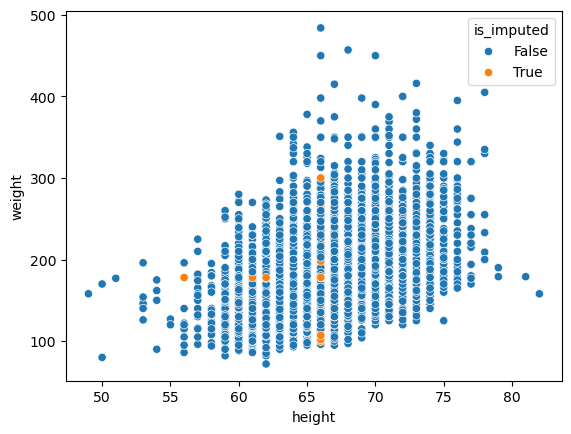

In [32]:
nhanes_df.select_columns('height','weight').missing.bind_shadow_matrix(True,False, suffix="_imp").assign(height = lambda df: df.height.fillna(value = df.height.mean().round()),weight = lambda df: df.weight.fillna(value=df.weight.mean().round())).missing.scatter_imputation_plot(x='height',y='weight')
plt.show()